#### Environment: pt_fpad  
Python: 3.10.4     
Pytorch: 2.1.1+cu118

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim
import os
import random
import cv2
import numpy as np

In [5]:
class_label_real = 0
class_label_attack = 1

Replay Mobile Dataset:

Training -> 312 (Real 120, Attack 192) ->  312/1030 * 100 = 30.29%  
Validation -> 416 (Real 160, Attack 256) -> 416/1030 * 100 = 40.38%  
Testing -> 302 (Real 110, Attack 192) -> 302/1030 * 100 = 29.32%  
Total = 1030  

Replay Attack Dataset:  
Training -> 360 (Real 60, Attack Fixed 150, Attack Hand 150) ->  360/1200 * 100 = 30%  
Validation -> 360 (Real 60, Attack Fixed 150, Attack Hand 150) -> 360/1200 * 100 = 30%  
Testing -> 480 (Real 80, Attack Fixed 200, Attack Hand 200) -> 480/1200 * 100 = 40%  
Total = 1200  

Rose-Youtu Dataset:  
Training -> 1397 (Real 358, Attack 1039) -> 1397/3495 * 100 = 40%  
Validation -> 350 (Real 90, Attack 260) -> 350/3495 * 100 = 10%  
Testing -> 1748 (Real 449, Attack 1299) -> 1748/3495 * 100 = 50%   
Total = 3495




In [6]:
# Example
# Provide dataset path for Replay Mobile and Rose Youtu Datasets e.g 
# data_path_train_real = '/home/taha/FASdatasets/Sohail/Rose_Youtu/train/real'
# data_path_train_attack = '/home/taha/FASdatasets/Sohail/Rose_Youtu/train/attack'

# For Replay Attack Dataset e.g.
# data_path_train_real = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/real'
# data_path_train_attack_fixed = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/attack/fixed'
# data_path_train_attack_hand = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/attack/hand'

# Follow the same above steps for Validation and Test Datasets

data_path_train_real = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/real'
# data_path_train_attack = '/home/taha/FASdatasets/Sohail/Rose_Youtu/train/attack'
data_path_train_attack_fixed = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/attack/fixed'
data_path_train_attack_hand = '/home/taha/FASdatasets/Sohail/Replay_Attack/train/attack/hand'

data_path_devel_real = '/home/taha/FASdatasets/Sohail/Replay_Attack/devel/real'
# data_path_devel_attack = '/home/taha/FASdatasets/Sohail/Rose_Youtu/devel/attack'
data_path_devel_attack_fixed = '/home/taha/FASdatasets/Sohail/Replay_Attack/devel/attack/fixed'
data_path_devel_attack_hand = '/home/taha/FASdatasets/Sohail/Replay_Attack/devel/attack/hand'

data_path_test_real = '/home/taha/FASdatasets/Sohail/Replay_Attack/test/real'
# data_path_test_attack = '/home/taha/FASdatasets/Sohail/Rose_Youtu/test/attack'
data_path_test_attack_fixed = '/home/taha/FASdatasets/Sohail/Replay_Attack/test/attack/fixed'
data_path_test_attack_hand = '/home/taha/FASdatasets/Sohail/Replay_Attack/test/attack/hand'

In [7]:
def load_samples(path, class_label, transform): #Select N frames returned from read_all_frames and assign labels to all samples of same class
        frames = read_all_frames(path)
        total_frames = list(range(0, frames.shape[0], 1))
        selected_samples = random.sample(total_frames, 1)
        samples =[]
        # Assign the same class label to all samples
        label = class_label
        samples =(transform(frames[selected_samples].squeeze()), label)     
        return samples

def read_all_frames(video_path): # reads all frames from a particular video and converts them to PyTorch tensors.
    frame_list = []
    video = cv2.VideoCapture(video_path)
    success = True
    while success:
        success, frame = video.read()
        if success:
            frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA) #framesize kept 40, 30 as mentioned in paper but 224, 224 is also fine 
            frame_list.append(frame)
    frame_list = np.array(frame_list)
    return frame_list

class VideoDataset(Dataset):
    def __init__(self, data_path, class_label):
        self.data_path = data_path #path for directory containing video files
        self.video_files = [file for file in os.listdir(data_path) if file.endswith('.mov')] #list of video files in the specified directory #.mov for RA and RM, .mp4 for RY
        self.class_label = class_label #manually assign class_label for your desired class while loading
        self.data_length = len(self.video_files) 
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self): # returns the total number of samples in the dataset
        return self.data_length

    def __getitem__(self, idx): # loads and returns a sample from the dataset at the given index
        file = self.video_files[idx]
        path = os.path.join(self.data_path, file)
        frames= load_samples(path, self.class_label, self.transform)

        return frames

In [8]:
# Create datasets for Replay Mobile and Rose Youtu Datasets

train_dataset_real = VideoDataset(data_path_train_real, class_label_real)
# train_dataset_attack = VideoDataset(data_path_train_attack, class_label_attack)

# For Replay Attack Dataset
train_dataset_attack_fixed = VideoDataset(data_path_train_attack_fixed, class_label_attack)
train_dataset_attack_hand = VideoDataset(data_path_train_attack_hand, class_label_attack)
# Same steps follow for Validation and Test Datasets

val_dataset_real = VideoDataset(data_path_devel_real, class_label_real)
# val_dataset_attack = VideoDataset(data_path_devel_attack, class_label_attack)
val_dataset_attack_fixed = VideoDataset(data_path_devel_attack_fixed, class_label_attack)
val_dataset_attack_hand = VideoDataset(data_path_devel_attack_hand, class_label_attack)

test_dataset_real = VideoDataset(data_path_test_real, class_label_real)
# test_dataset_attack = VideoDataset(data_path_test_attack, class_label_attack)
test_dataset_attack_fixed = VideoDataset(data_path_test_attack_fixed, class_label_attack)
test_dataset_attack_hand = VideoDataset(data_path_test_attack_hand, class_label_attack)

In [9]:
# Create DataLoader for Replay Mobile and Rose Youtu Datasets

train_loader_real = DataLoader(train_dataset_real, batch_size=1, shuffle=True)
# train_loader_attack = DataLoader(train_dataset_attack, batch_size=1, shuffle=True)

# For Replay Attack Dataset
train_loader_attack_fixed = DataLoader(train_dataset_attack_fixed, batch_size=1, shuffle=True)
train_loader_attack_hand = DataLoader(train_dataset_attack_hand, batch_size=1, shuffle=True)
# Same steps follow for Validation and Test DataLoader

val_loader_real = DataLoader(val_dataset_real, batch_size=1, shuffle=False)
# val_loader_attack = DataLoader(val_dataset_attack, batch_size=1, shuffle=False)
val_loader_attack_fixed = DataLoader(val_dataset_attack_fixed, batch_size=1, shuffle=False)
val_loader_attack_hand = DataLoader(val_dataset_attack_hand, batch_size=1, shuffle=False)

test_loader_real = DataLoader(test_dataset_real, batch_size=1, shuffle=False)
# test_loader_attack = DataLoader(test_dataset_attack, batch_size=1, shuffle=False)
test_loader_attack_fixed = DataLoader(test_dataset_attack_fixed, batch_size=1, shuffle=False)
test_loader_attack_hand = DataLoader(test_dataset_attack_hand, batch_size=1, shuffle=False)

In [10]:
# Concatenate datasets for Replay Mobile and Rose Youtu Datasets
# concatenated_train_dataset = ConcatDataset([train_dataset_real, train_dataset_attack])
# concatenated_val_dataset = ConcatDataset([val_dataset_real, val_dataset_attack])
# concatenated_test_dataset = ConcatDataset([test_dataset_real, test_dataset_attack])

# Concatenate datasets for Replay Attack Dataset
concatenated_train_dataset = ConcatDataset([train_dataset_real, train_dataset_attack_fixed, train_dataset_attack_hand])
concatenated_val_dataset = ConcatDataset([val_dataset_real, val_dataset_attack_fixed, val_dataset_attack_hand])
concatenated_test_dataset = ConcatDataset([test_dataset_real, test_dataset_attack_fixed, test_dataset_attack_hand])

concatenated_train_loader = DataLoader(concatenated_train_dataset, batch_size=64, shuffle=True, pin_memory=False, num_workers=8)
concatenated_val_loader = DataLoader(concatenated_val_dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=8)
concatenated_test_loader = DataLoader(concatenated_test_dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=8)

In [11]:
# Print dataset sizes
print(f"Training set size: {len(concatenated_train_dataset)}")
print(f"Validation set size: {len(concatenated_val_dataset)}")
print(f"Test set size: {len(concatenated_test_dataset)}")

Training set size: 360
Validation set size: 360
Test set size: 480


In [12]:
# Load pre-trained ResNet18
# model = models.resnet18(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2) #default in_features =1280, out_features = 1000
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

/home/taha/anaconda3/envs/pt_fpad/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/taha/anaconda3/envs/pt_fpad/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

# Set up early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for train_images, train_labels in concatenated_train_loader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()

        # calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1) # _ contain max value, train_predicted contain the indices where maximum value occured
        train_correct_predictions += (train_predicted == train_labels).sum().item() 
        total_train_samples += train_labels.size(0)
            
    train_total_loss = running_loss / len(concatenated_train_loader)
    train_accuracy = train_correct_predictions / total_train_samples * 100
    train_losses.append(train_total_loss)
    train_accuracies.append(train_accuracy)

    val_running_loss = 0.0
    val_correct_prediction = 0
    total_val_samples = 0

    #Validation
    model.eval()
    with torch.no_grad():
        for val_images, val_labels in concatenated_val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_op = model(val_images)
            val_loss = criterion(val_op, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_op, 1)
            val_correct_prediction += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
        
        val_total_loss = val_running_loss / len(concatenated_val_loader)
        val_accuracy = val_correct_prediction / total_val_samples * 100
        val_losses.append(val_total_loss)
        val_accuracies.append(val_accuracy)

    # Check if validation loss has improved
    if val_total_loss < best_loss:
        best_loss = val_total_loss
        counter = 0
        # Save the model if needed
        # torch.save(model.state_dict(), 'best_model.pth')

    else:
        counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_total_loss: .4f}, Best Loss: {best_loss: .4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/50, Training Loss: 0.2699, Training Accuracy: 82.78%, Validation Loss:  0.1027, Best Loss:  0.1027, Validation Accuracy: 95.28%
Epoch 2/50, Training Loss: 0.0115, Training Accuracy: 100.00%, Validation Loss:  0.7018, Best Loss:  0.1027, Validation Accuracy: 78.33%
Epoch 3/50, Training Loss: 0.0495, Training Accuracy: 97.50%, Validation Loss:  0.0459, Best Loss:  0.0459, Validation Accuracy: 98.61%
Epoch 4/50, Training Loss: 0.0104, Training Accuracy: 99.72%, Validation Loss:  0.4034, Best Loss:  0.0459, Validation Accuracy: 89.72%
Epoch 5/50, Training Loss: 0.0105, Training Accuracy: 99.72%, Validation Loss:  0.0920, Best Loss:  0.0459, Validation Accuracy: 98.33%
Epoch 6/50, Training Loss: 0.0063, Training Accuracy: 99.72%, Validation Loss:  0.0074, Best Loss:  0.0074, Validation Accuracy: 99.72%
Epoch 7/50, Training Loss: 0.0007, Training Accuracy: 100.00%, Validation Loss:  0.0085, Best Loss:  0.0074, Validation Accuracy: 99.44%
Epoch 8/50, Training Loss: 0.0011, Training Ac

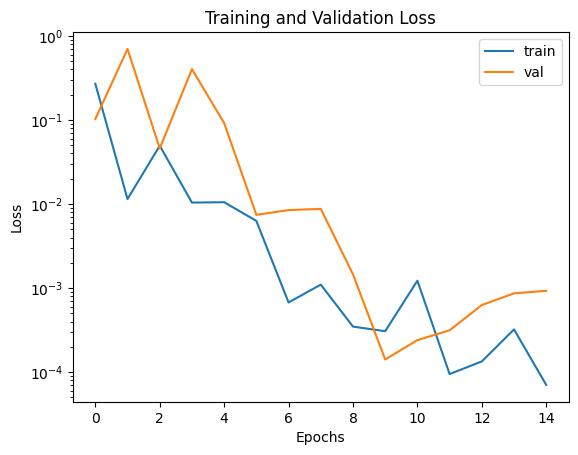

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.show()

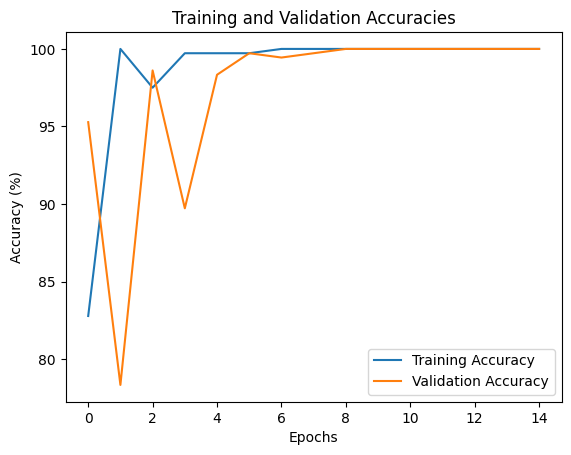

In [17]:
plt.figure()
plt.title("Training and Validation Accuracies")
plt.plot(train_accuracies,label="Training Accuracy")
plt.plot(val_accuracies,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [18]:
# Evaluate on the test set
test_correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    
    test_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    test_predicted_cat_labels = torch.empty(0, dtype=torch.int64, device=device)

    for test_images, test_labels in concatenated_test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_model_op = model(test_images)
        _, test_predicted = torch.max(test_model_op, 1)
        test_correct += (test_predicted == test_labels).sum().item() 
        test_total += test_labels.size(0)

        test_cat_labels = torch.cat((test_cat_labels, test_labels))
        test_predicted_cat_labels = torch.cat((test_predicted_cat_labels, test_predicted))

    test_accuracy = test_correct / test_total * 100  
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 100.00%


In [19]:
test_cat_labels_cpu = test_cat_labels.cpu()
test_predicted_cat_labels_cpu = test_predicted_cat_labels.cpu()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [21]:
tn, fp, fn, tp = confusion_matrix(test_cat_labels_cpu, test_predicted_cat_labels_cpu).ravel()

print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

acc_score = accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
prec_score = precision_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
recall = recall_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)

Y_I_val =(tp/(tp+fn)) + (tn/(tn+fp)) - 1
sensitivity_val = tp / (tp + fn)
specificity_val = tn / (tn + fp)
f1score_val = 2 * tp / (2 * tp + fp + fn)
FAR = fp/(fp + tn)
FRR = fn/(fn + tp)
HTER_val = (FAR + FRR)/2
EER = (fp+fn)/(tn+fp+fn+tp)
val_bacc = balanced_accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)


print('Testing Results')
print(30*'-')
print('Acc:', acc_score, '\nSen:', sensitivity_val, '\nSpec:', specificity_val, '\nYI:', Y_I_val, '\nF1:', f1score_val, '\nPrec:', prec_score, '\nRecall:', recall, '\nHTER:', HTER_val, '\nEER:', EER, '\nBACC:', val_bacc)

TN: 80, FP: 0, FN: 0, TP: 400
Testing Results
------------------------------
Acc: 1.0 
Sen: 1.0 
Spec: 1.0 
YI: 1.0 
F1: 1.0 
Prec: 1.0 
Recall: 1.0 
HTER: 0.0 
EER: 0.0 
BACC: 1.0
